# TODO

- [x] filter for weird routes (over land, non-smooth, etc.)
- [ ] Check dependency of typical best cost and typical runtime on hyperparameters

## Filtering for broken routes by length

Let's cut away routes which are more than twice as long as the seed route.

In [1]:
from pathlib import Path
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import shapely
from matplotlib import pyplot as plt

from ship_routing.app.routing import RoutingResult, RoutingLog
import msgpack
from tqdm.auto import tqdm

In [2]:
data_file = Path("../../tuning_results/results.msgpack")

In [3]:
def load_results(msgpack_file: str, nitems: int = None) -> dict[str, RoutingResult]:
    """Load all results from msgpack file.

    Parameters
    ----------
    msgpack_file : str
        Path to msgpack file containing serialized results.
    nitems: int (optional)
        Restrict to first nitems items.

    Returns
    -------
    dict[str, RoutingResult]
        Dictionary mapping result keys to RoutingResult objects.
    """
    with open(msgpack_file, "rb") as f:
        raw_results = msgpack.unpack(f, raw=False)

    return {
        key: RoutingResult.from_msgpack(value) for key, value in tqdm(list(raw_results.items())[:nitems])
    }

In [4]:
results = load_results(data_file, 1_000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
len(results)

1000

In [6]:
def remove_freak_results(routing_results_dict: dict = None):
    """There shold not be elite routes which are shorter than the original one."""
    return {
        k: v
        for k, v in tqdm(routing_results_dict.items())
        if not any([
            m.route.length_meters < v.seed_member.route.length_meters 
            for m in v.elite_population.members
        ])
    }

In [7]:
len(remove_freak_results(results))

  0%|          | 0/1000 [00:00<?, ?it/s]

999

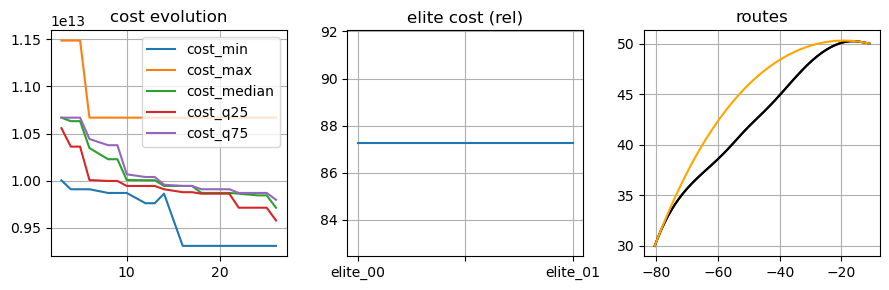

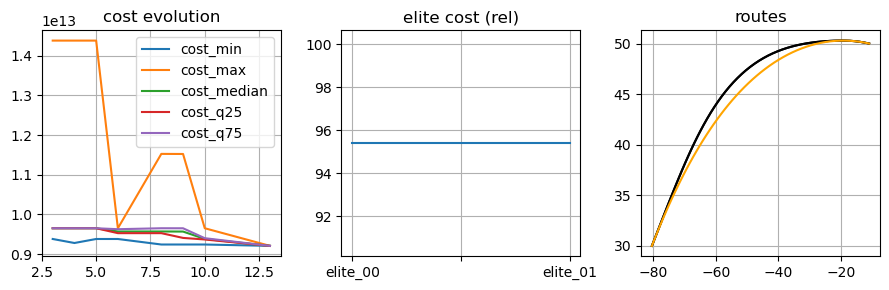

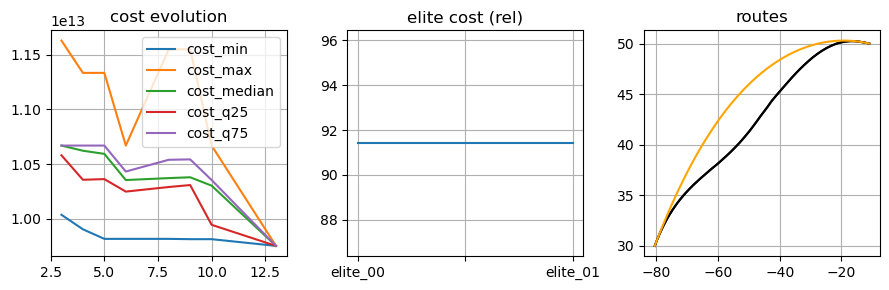

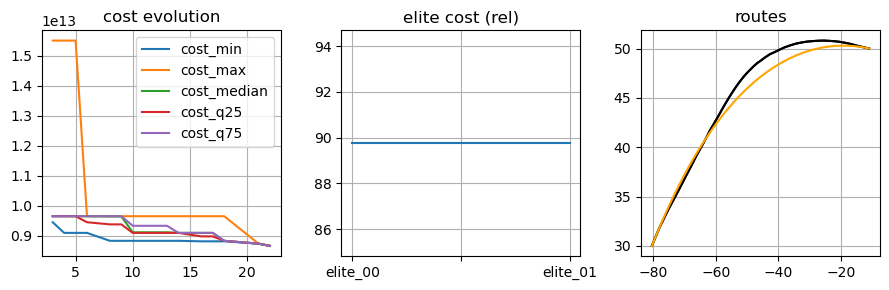

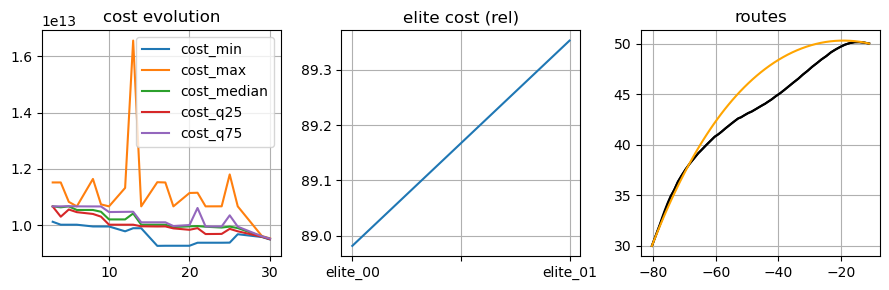

In [8]:
res_list = list(results.values())
for _res in res_list[-5:]:
    _res.plot_full_routing_result()

In [9]:
def get_journey_params_df(routing_results_dict: dict = None):
    def _fix_waypoints(dct):
        dct['lon_waypoints'] = str(dct['lon_waypoints'])
        dct['lat_waypoints'] = str(dct['lat_waypoints'])
        return dct
        
    df = pd.concat(
        [
            pd.DataFrame(
                _fix_waypoints(rr.logs.config["journey"]),
                index=[
                    f,
                ],
            )
            for f, rr in routing_results_dict.items()
        ]
    ).add_prefix("journey_")
    df = df.assign(
        journey_lon_waypoints=df["journey_lon_waypoints"].astype("category"),
        journey_lat_waypoints=df["journey_lat_waypoints"].astype("category"),
    )
    df.index = df.index.rename("filename")
    return df

In [10]:
%pdb off

Automatic pdb calling has been turned OFF


In [11]:
df_journey = get_journey_params_df(results)
df_journey

,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours
filename,,,,,,
result:2025-12-04T03-27-48.579_f1d9d606-6d5b-400b-9a6d-3d572cf610aa,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-04T05-16-40.968_0cc6d9d6-84ac-4dd9-afb5-f463218b4aae,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-03T20-13-35.245_8bca86c3-7a97-4f3a-a2a5-8afa3dea730d,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-03T21-54-19.876_b9cf3c9d-00b8-44b0-b93c-3913457c294a,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-04T05-37-16.035_c1614e3b-6000-4c58-9c49-9def1ab5cda4,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
...,...,...,...,...,...,...
result:2025-12-03T18-06-42.994_d2a17f9c-7455-4475-b3d4-58df7f67bab9,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-04T06-28-28.431_babbbf88-c51e-4d66-8276-2aefddb9094e,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-03T18-30-19.644_9e707ec2-9300-4f34-8509-adad808640f6,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0


In [12]:
def get_hyper_params_df(routing_results_dict: dict = None):
    df = pd.concat(
        [
            pd.DataFrame(
                rr.logs.config["hyper"],
                index=[
                    f,
                ],
            )
            for f, rr in routing_results_dict.items()
        ]
    ).add_prefix("hyper_")
    df = df.assign(
        hyper_crossover_strategy=df["hyper_crossover_strategy"].astype("category")
    )
    df.index = df.index.rename("filename")
    return df

In [13]:
df_params = pd.merge(
    get_hyper_params_df(results), 
    get_journey_params_df(results), 
    left_index=True, 
    right_index=True,
)
df_params

,hyper_population_size,hyper_random_seed,hyper_generations,hyper_selection_quantile,hyper_selection_acceptance_rate_warmup,hyper_selection_acceptance_rate,hyper_mutation_width_fraction,hyper_mutation_displacement_fraction,hyper_mutation_iterations,hyper_crossover_strategy,...,hyper_learning_rate_time,hyper_learning_rate_space,hyper_time_increment,hyper_distance_increment,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-04T03-27-48.579_f1d9d606-6d5b-400b-9a6d-3d572cf610aa,32,2,2,0.5,0.3,0.1,0.9,0.1,3,random,...,0.5,0.5,1200.0,10000.0,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-04T05-16-40.968_0cc6d9d6-84ac-4dd9-afb5-f463218b4aae,64,7,2,0.2,0.3,0.0,0.9,0.1,3,minimal_cost,...,0.5,0.5,1200.0,10000.0,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-03T20-13-35.245_8bca86c3-7a97-4f3a-a2a5-8afa3dea730d,16,5,4,0.2,0.3,0.0,0.9,0.1,2,minimal_cost,...,0.5,0.5,1200.0,10000.0,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-03T21-54-19.876_b9cf3c9d-00b8-44b0-b93c-3913457c294a,64,5,2,0.5,0.3,0.2,0.9,0.1,2,random,...,0.5,0.5,1200.0,10000.0,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-04T05-37-16.035_c1614e3b-6000-4c58-9c49-9def1ab5cda4,32,4,4,0.2,0.3,0.0,0.9,0.1,3,minimal_cost,...,0.5,0.5,1200.0,10000.0,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-03T18-06-42.994_d2a17f9c-7455-4475-b3d4-58df7f67bab9,64,5,6,0.5,0.3,0.0,0.9,0.1,2,minimal_cost,...,0.5,0.5,1200.0,10000.0,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-04T06-28-28.431_babbbf88-c51e-4d66-8276-2aefddb9094e,64,11,2,0.2,0.3,0.1,0.9,0.1,1,random,...,0.5,0.5,1200.0,10000.0,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0
result:2025-12-03T18-30-19.644_9e707ec2-9300-4f34-8509-adad808640f6,64,10,2,0.5,0.3,0.2,0.9,0.1,1,random,...,0.5,0.5,1200.0,10000.0,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0


In [14]:
df_params.describe().T

,count,mean,std,min,25%,50%,75%,max
hyper_population_size,1000.0,37.1680,2.006226e+01,16.0,16.0,32.0,64.0,64.0
hyper_random_seed,1000.0,5.4370,3.469304e+00,0.0,2.0,5.0,8.0,11.0
hyper_generations,1000.0,4.9020,2.251103e+00,2.0,2.0,4.0,6.0,8.0
hyper_selection_quantile,1000.0,0.3533,1.500387e-01,0.2,0.2,0.5,0.5,0.5
hyper_selection_acceptance_rate_warmup,1000.0,0.3000,1.110779e-16,0.3,0.3,0.3,0.3,0.3
hyper_selection_acceptance_rate,1000.0,0.0997,8.232063e-02,0.0,0.0,0.1,0.2,0.2
hyper_mutation_width_fraction,1000.0,0.9000,2.221557e-16,0.9,0.9,0.9,0.9,0.9
hyper_mutation_displacement_fraction,1000.0,0.1000,1.388473e-17,0.1,0.1,0.1,0.1,0.1
hyper_mutation_iterations,1000.0,2.0060,8.078469e-01,1.0,1.0,2.0,3.0,3.0
hyper_crossover_rounds,1000.0,1.0120,8.151813e-01,0.0,0.0,1.0,2.0,2.0


In [15]:
def get_runtime(routing_results_dict: dict = None):
    _records = []
    for f, rr in routing_results_dict.items():
        _records.extend(
            [
                {
                    "filename": f,
                    "runtime": rr.logs.to_dataframe().timestamp.max()
                    - rr.logs.to_dataframe().timestamp.min(),
                }
            ]
        )
    df = pd.DataFrame.from_records(_records).set_index("filename")
    df = df.assign(runtime_seconds=df.runtime.dt.total_seconds())
    return df

In [16]:
df_runtime = get_runtime(results)
df_runtime

,runtime,runtime_seconds
filename,,
result:2025-12-04T03-27-48.579_f1d9d606-6d5b-400b-9a6d-3d572cf610aa,0 days 00:03:18,198.0
result:2025-12-04T05-16-40.968_0cc6d9d6-84ac-4dd9-afb5-f463218b4aae,0 days 00:10:18,618.0
result:2025-12-03T20-13-35.245_8bca86c3-7a97-4f3a-a2a5-8afa3dea730d,0 days 00:04:54,294.0
result:2025-12-03T21-54-19.876_b9cf3c9d-00b8-44b0-b93c-3913457c294a,0 days 00:06:25,385.0
result:2025-12-04T05-37-16.035_c1614e3b-6000-4c58-9c49-9def1ab5cda4,0 days 00:09:22,562.0
...,...,...
result:2025-12-03T18-06-42.994_d2a17f9c-7455-4475-b3d4-58df7f67bab9,0 days 00:15:58,958.0
result:2025-12-04T06-28-28.431_babbbf88-c51e-4d66-8276-2aefddb9094e,0 days 00:09:24,564.0
result:2025-12-03T18-30-19.644_9e707ec2-9300-4f34-8509-adad808640f6,0 days 00:07:08,428.0


In [17]:
df_runtime.groupby(df_params.journey_lat_waypoints).runtime_seconds.describe()

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_71200/3546377973.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_runtime.groupby(df_params.journey_lat_waypoints).runtime_seconds.describe()


,count,mean,std,min,25%,50%,75%,max
journey_lat_waypoints,,,,,,,,
"[30.0, 50.0]",494.0,637.331984,463.413364,96.0,296.25,486.5,845.0,3636.0
"[50.0, 30.0]",506.0,638.090909,514.562026,95.0,291.50,482.0,819.5,4031.0


In [18]:
def get_elite(routing_results_dict: dict = None):
    _records = []
    for f, rr in routing_results_dict.items():
        seed_member = rr.seed_member
        _records.extend(
            [
                {
                    "filename": f,
                    "n_elite": n,
                    "elite_length_meters": m.route.length_meters,
                    "elite_length_relative": m.route.length_meters / seed_member.route.length_meters,
                    "elite_cost_absolute": m.cost,
                    "elite_cost_relative": m.cost / seed_member.cost,
                }
                for n, m in enumerate(rr.elite_population.members)
            ]
        )
    return pd.DataFrame.from_records(_records).set_index("filename")

In [19]:
df_elite = get_elite(results)
df_elite

,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative
filename,,,,,
result:2025-12-04T03-27-48.579_f1d9d606-6d5b-400b-9a6d-3d572cf610aa,0,6.110164e+06,1.002761,9.028301e+12,0.935503
result:2025-12-04T03-27-48.579_f1d9d606-6d5b-400b-9a6d-3d572cf610aa,1,6.110164e+06,1.002761,9.028301e+12,0.935503
result:2025-12-04T05-16-40.968_0cc6d9d6-84ac-4dd9-afb5-f463218b4aae,0,6.102030e+06,1.001426,8.750225e+12,0.906689
result:2025-12-04T05-16-40.968_0cc6d9d6-84ac-4dd9-afb5-f463218b4aae,1,6.102030e+06,1.001426,8.750225e+12,0.906689
result:2025-12-03T20-13-35.245_8bca86c3-7a97-4f3a-a2a5-8afa3dea730d,0,6.175733e+06,1.013521,9.773725e+12,0.916114
...,...,...,...,...,...
result:2025-12-03T18-30-19.644_9e707ec2-9300-4f34-8509-adad808640f6,1,6.185035e+06,1.015048,9.752420e+12,0.914117
result:2025-12-04T03-50-28.761_a7def3e1-9315-4df0-ad8c-561647159bc4,0,6.112764e+06,1.003187,8.661882e+12,0.897535
result:2025-12-04T03-50-28.761_a7def3e1-9315-4df0-ad8c-561647159bc4,1,6.112764e+06,1.003187,8.661882e+12,0.897535


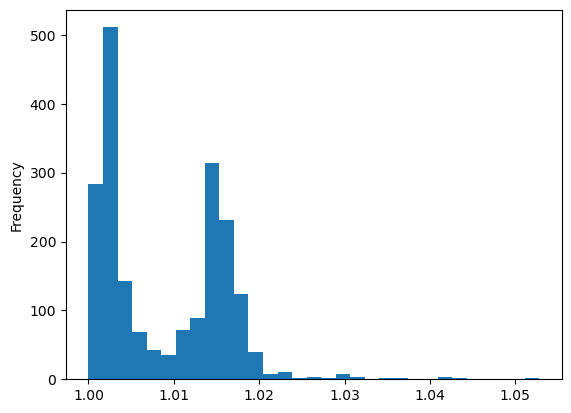

In [20]:
df_elite.elite_length_relative.plot.hist(bins=31);

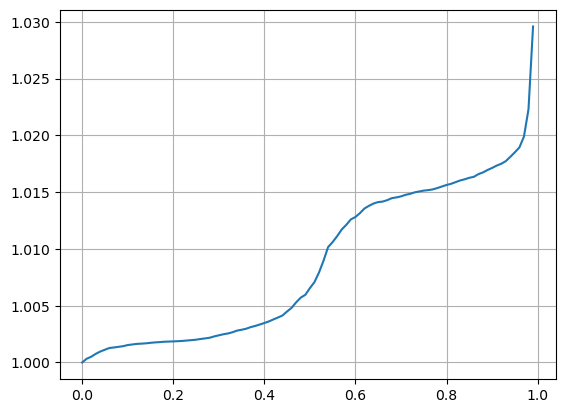

In [25]:
ax = df_elite.elite_length_relative.quantile(np.arange(0, 1, 0.01)).plot(logy=False, grid=True);

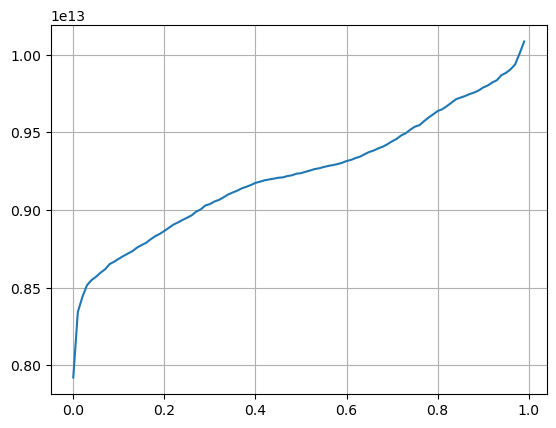

In [26]:
ax = df_elite.elite_cost_absolute.quantile(np.arange(0, 1, 0.01)).plot(logy=False, grid=True);

In [27]:
df_merged = (
    df_params
    .merge(df_elite, left_index=True, right_index=True, how="inner")
    .merge(df_runtime, left_index=True, right_index=True, how="inner")
)
df_merged

,hyper_population_size,hyper_random_seed,hyper_generations,hyper_selection_quantile,hyper_selection_acceptance_rate_warmup,hyper_selection_acceptance_rate,hyper_mutation_width_fraction,hyper_mutation_displacement_fraction,hyper_mutation_iterations,hyper_crossover_strategy,...,journey_time_end,journey_speed_knots,journey_time_resolution_hours,n_elite,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative,runtime,runtime_seconds
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-04T03-27-48.579_f1d9d606-6d5b-400b-9a6d-3d572cf610aa,32,2,2,0.5,0.3,0.1,0.9,0.1,3,random,...,2021-01-14T17:00:51,10.0,6.0,0,6.110164e+06,1.002761,9.028301e+12,0.935503,0 days 00:03:18,198.0
result:2025-12-04T03-27-48.579_f1d9d606-6d5b-400b-9a6d-3d572cf610aa,32,2,2,0.5,0.3,0.1,0.9,0.1,3,random,...,2021-01-14T17:00:51,10.0,6.0,1,6.110164e+06,1.002761,9.028301e+12,0.935503,0 days 00:03:18,198.0
result:2025-12-04T05-16-40.968_0cc6d9d6-84ac-4dd9-afb5-f463218b4aae,64,7,2,0.2,0.3,0.0,0.9,0.1,3,minimal_cost,...,2021-01-14T17:00:51,10.0,6.0,0,6.102030e+06,1.001426,8.750225e+12,0.906689,0 days 00:10:18,618.0
result:2025-12-04T05-16-40.968_0cc6d9d6-84ac-4dd9-afb5-f463218b4aae,64,7,2,0.2,0.3,0.0,0.9,0.1,3,minimal_cost,...,2021-01-14T17:00:51,10.0,6.0,1,6.102030e+06,1.001426,8.750225e+12,0.906689,0 days 00:10:18,618.0
result:2025-12-03T20-13-35.245_8bca86c3-7a97-4f3a-a2a5-8afa3dea730d,16,5,4,0.2,0.3,0.0,0.9,0.1,2,minimal_cost,...,2021-01-14T17:00:51,10.0,6.0,0,6.175733e+06,1.013521,9.773725e+12,0.916114,0 days 00:04:54,294.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-03T18-30-19.644_9e707ec2-9300-4f34-8509-adad808640f6,64,10,2,0.5,0.3,0.2,0.9,0.1,1,random,...,2021-01-14T17:00:51,10.0,6.0,1,6.185035e+06,1.015048,9.752420e+12,0.914117,0 days 00:07:08,428.0
result:2025-12-04T03-50-28.761_a7def3e1-9315-4df0-ad8c-561647159bc4,64,0,4,0.2,0.3,0.0,0.9,0.1,3,minimal_cost,...,2021-01-14T17:00:51,10.0,6.0,0,6.112764e+06,1.003187,8.661882e+12,0.897535,0 days 00:11:35,695.0
result:2025-12-04T03-50-28.761_a7def3e1-9315-4df0-ad8c-561647159bc4,64,0,4,0.2,0.3,0.0,0.9,0.1,3,minimal_cost,...,2021-01-14T17:00:51,10.0,6.0,1,6.112764e+06,1.003187,8.661882e+12,0.897535,0 days 00:11:35,695.0


In [28]:
df_merged.columns

Index(['hyper_population_size', 'hyper_random_seed', 'hyper_generations',
       'hyper_selection_quantile', 'hyper_selection_acceptance_rate_warmup',
       'hyper_selection_acceptance_rate', 'hyper_mutation_width_fraction',
       'hyper_mutation_displacement_fraction', 'hyper_mutation_iterations',
       'hyper_crossover_strategy', 'hyper_crossover_rounds',
       'hyper_num_elites', 'hyper_gd_iterations', 'hyper_learning_rate_time',
       'hyper_learning_rate_space', 'hyper_time_increment',
       'hyper_distance_increment', 'journey_lon_waypoints',
       'journey_lat_waypoints', 'journey_time_start', 'journey_time_end',
       'journey_speed_knots', 'journey_time_resolution_hours', 'n_elite',
       'elite_length_meters', 'elite_length_relative', 'elite_cost_absolute',
       'elite_cost_relative', 'runtime', 'runtime_seconds'],
      dtype='object')

In [29]:
df_analysis = (
  df_merged
  .groupby(level=0)  # group by filename
  .agg({
      'runtime_seconds': 'first',  # same for all rows
      **{col: 'first' for col in df_merged.columns if col.startswith('hyper_') or col.startswith('journey_')},
      **{col: 'first' for col in df_merged.columns if col.startswith('elite_')}
  })
)
df_analysis

,runtime_seconds,hyper_population_size,hyper_random_seed,hyper_generations,hyper_selection_quantile,hyper_selection_acceptance_rate_warmup,hyper_selection_acceptance_rate,hyper_mutation_width_fraction,hyper_mutation_displacement_fraction,hyper_mutation_iterations,...,journey_lon_waypoints,journey_lat_waypoints,journey_time_start,journey_time_end,journey_speed_knots,journey_time_resolution_hours,elite_length_meters,elite_length_relative,elite_cost_absolute,elite_cost_relative
filename,,,,,,,,,,,,,,,,,,,,,
result:2025-12-03T17-28-50.680_ca0a1b9a-a494-4eec-8fa0-b65971e8217e,152.0,16,4,2,0.2,0.3,0.1,0.9,0.1,2,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.195007e+06,1.016684,9.516296e+12,0.891985
result:2025-12-03T17-28-53.276_11644e14-447c-42a2-ac45-fd6d1fd9fdba,160.0,16,1,4,0.2,0.3,0.1,0.9,0.1,1,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.175330e+06,1.013455,1.013513e+13,0.949989
result:2025-12-03T17-29-08.807_bd05da14-8809-4670-ad28-b3734a49324d,181.0,16,8,4,0.5,0.3,0.0,0.9,0.1,1,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.189251e+06,1.015740,9.914704e+12,0.929328
result:2025-12-03T17-29-32.251_1c8d409e-08a5-4965-b883-e2663c4e23d1,202.0,16,0,2,0.2,0.3,0.2,0.9,0.1,1,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.186955e+06,1.015363,9.626627e+12,0.902326
result:2025-12-03T17-30-30.192_5dfa0fa9-dae1-4d4b-aa0b-cba5e0fa9807,251.0,16,10,4,0.2,0.3,0.0,0.9,0.1,2,...,"[-80.5, -11.0]","[30.0, 50.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.178743e+06,1.014015,9.186693e+12,0.861090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result:2025-12-04T10-05-29.960_d0bda8c9-a119-4c1f-aa5c-6739f47ce084,817.0,16,2,8,0.5,0.3,0.1,0.9,0.1,3,...,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.106013e+06,1.002079,9.030450e+12,0.935725
result:2025-12-04T10-08-49.938_850dcaf0-f84d-4a28-9832-6afcd8316194,424.0,16,7,6,0.2,0.3,0.1,0.9,0.1,3,...,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.104621e+06,1.001851,8.897426e+12,0.921942
result:2025-12-04T10-27-17.889_11c40df7-8283-4d8a-a972-3221212f9d07,4031.0,64,3,8,0.2,0.3,0.2,0.9,0.1,2,...,"[-11.0, -80.5]","[50.0, 30.0]",2021-01-01T00:00,2021-01-14T17:00:51,10.0,6.0,6.129414e+06,1.005920,8.342530e+12,0.864444


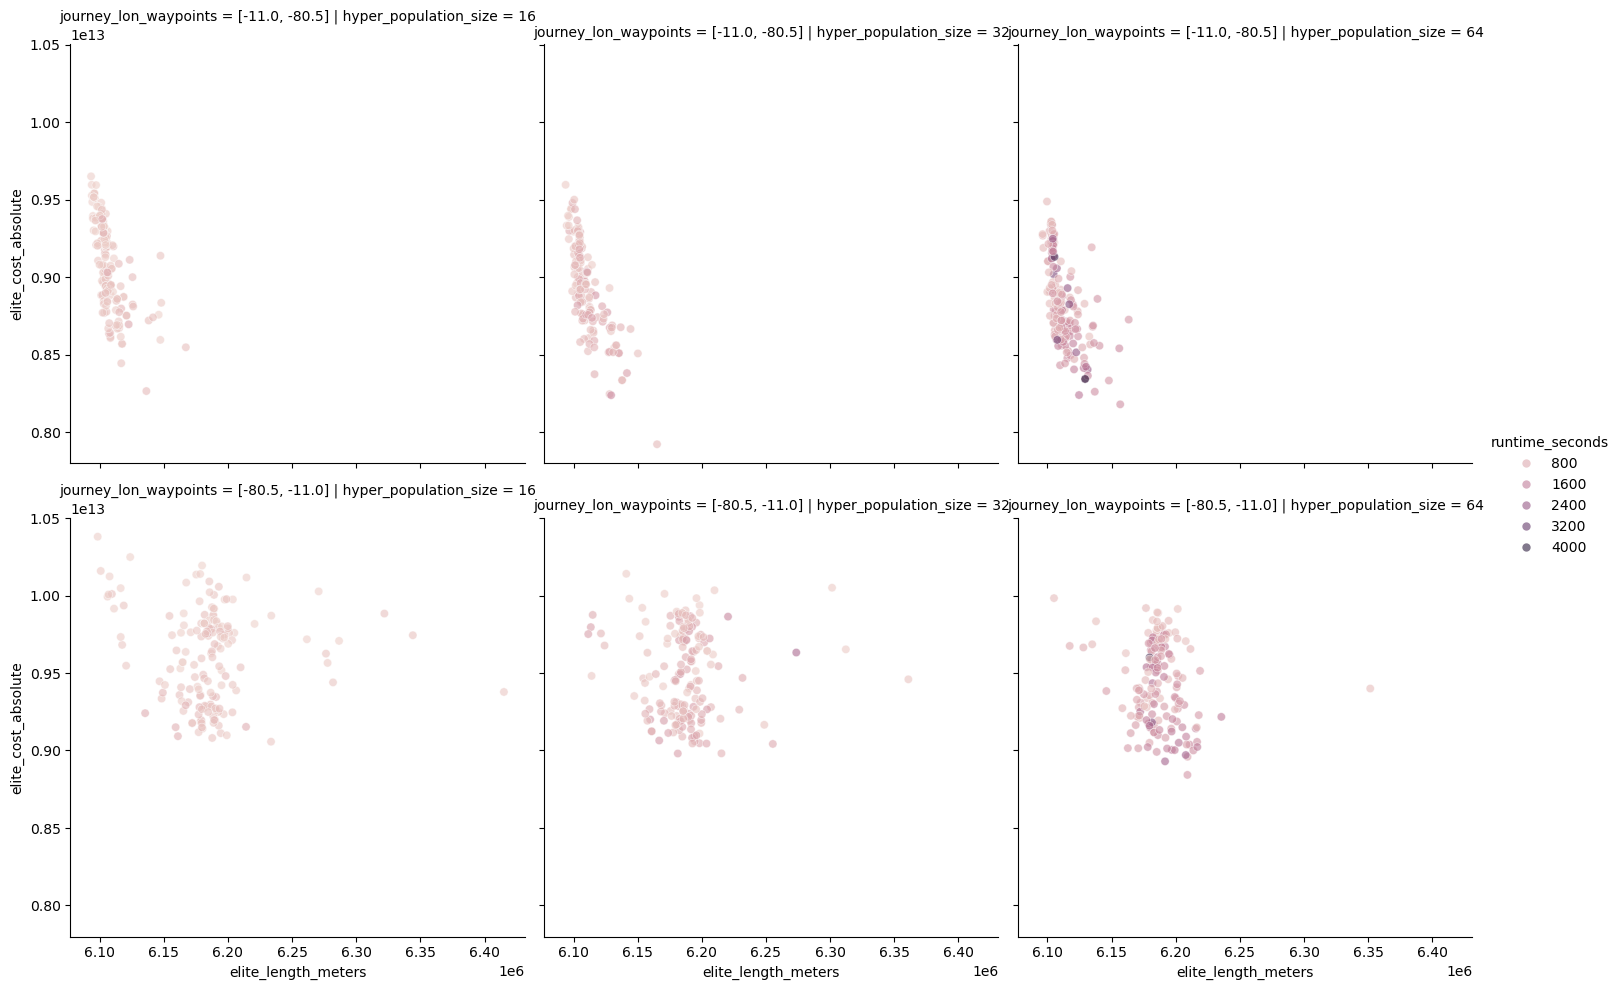

In [30]:
sns.relplot(
    data=df_analysis,
    x='elite_length_meters',
    y='elite_cost_absolute',
    hue='runtime_seconds',
    col='hyper_population_size',
    row='journey_lon_waypoints',
    alpha=0.6,
)

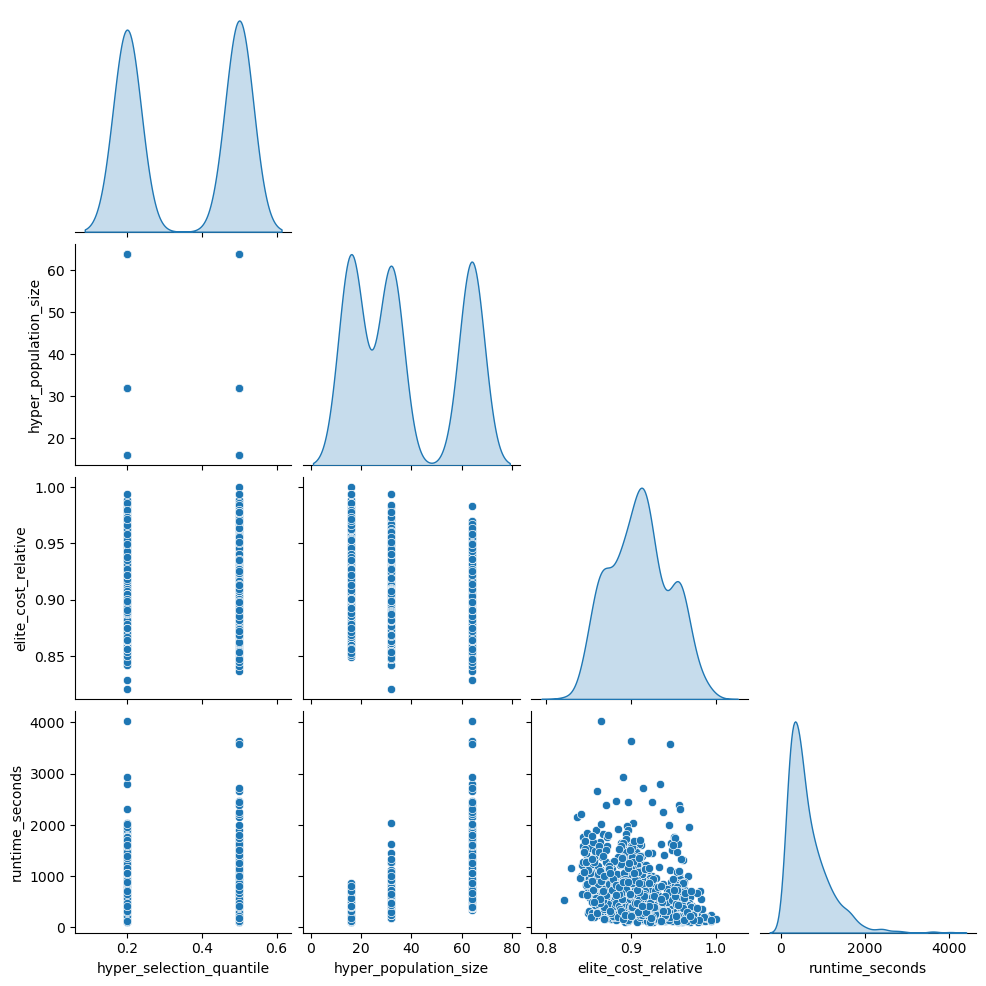

In [31]:
# Select key hyperparameters
key_vars = [
  'hyper_selection_quantile',
  'hyper_population_size',
  'elite_cost_relative',
  'runtime_seconds'
]
sns.pairplot(df_analysis[key_vars], diag_kind='kde', corner=True)

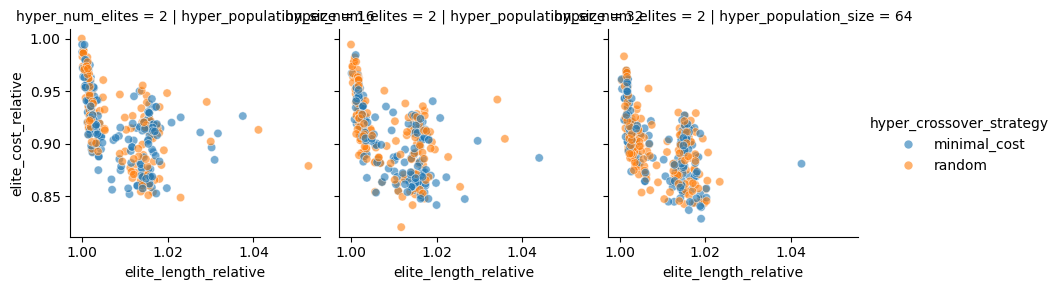

In [32]:
 sns.relplot(
      data=df_analysis,
      x='elite_length_relative',
      y='elite_cost_relative',
      hue='hyper_crossover_strategy',
      col='hyper_population_size',
      row='hyper_num_elites',
      kind='scatter',
      alpha=0.6,
      height=3
  )

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_71200/122762472.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])


<Axes: xlabel='hyper_population_size', ylabel='hyper_generations-hyper_crossover_strategy'>

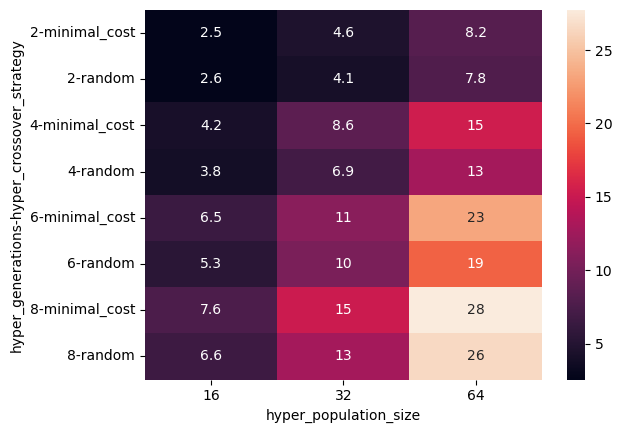

In [33]:
sns.heatmap(
    df_merged
    .groupby(['hyper_population_size', 'hyper_generations', 'hyper_crossover_strategy'])
    .runtime
    .median()
    .dt.total_seconds()
    .unstack(0) / 60,
    annot=True
)

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_71200/894925711.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])


<Axes: xlabel='hyper_generations', ylabel='journey_lon_waypoints-hyper_population_size'>

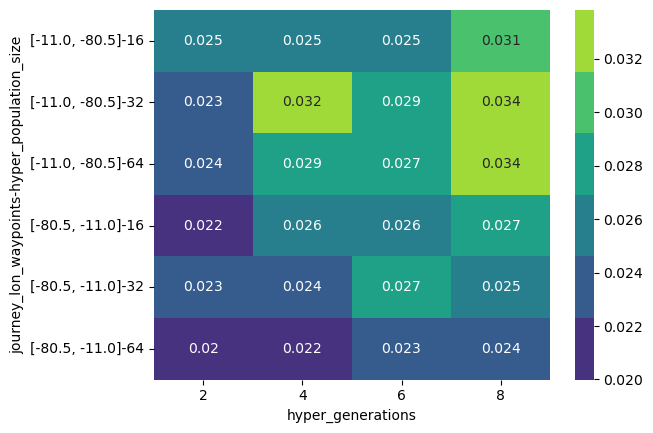

In [34]:
sns.heatmap(
    df_merged
    .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])
    .elite_cost_relative
    # .quantile(np.linspace(0, 1, 11))
    .std()
    .unstack(-1),
    annot=True,
    cmap=sns.color_palette("viridis")
)

/var/folders/w1/m9mm9h9167z_gcfzfffr0rgsh6j6kj/T/ipykernel_71200/3988838336.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])


<Axes: ylabel='journey_lon_waypoints-hyper_population_size-hyper_generations'>

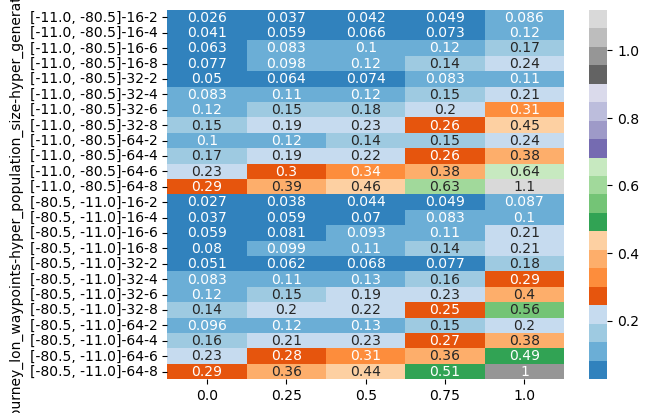

In [35]:
sns.heatmap(
    (df_merged
    .groupby(['journey_lon_waypoints', 'hyper_population_size', 'hyper_generations'])
    .runtime_seconds
    .quantile(np.linspace(0, 1, 5)) / 3600)
    .unstack(-1),
    annot=True,
    cmap=sns.color_palette("tab20c")
)